## Univariate LSTM-RNN Sumatera Selatan Percobaan 1

### 1. Deklarasi Pustaka

In [1]:
# pustaka untuk manipulasi data
import pandas as pd
from pandas import concat
from pandas import DataFrame
from pandas import read_csv
from pandas import read_excel
import numpy as np
from numpy import concatenate
from numpy import array

# pustaka untuk waktu komputasi
import time
from datetime import datetime

# Pustaka untuk visualisasi data
import seaborn as sns
from matplotlib import pyplot
from matplotlib import pyplot as plt

# Pustaka untuk visualisasi acf dan pacf
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
        
# Pustaka untuk membuat data latih dan data uji.
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Pustaka untuk membuat model prediksi LSTM-RNN
import itertools
import tensorflow as tf
from keras.models import Sequential
from keras.layers import RNN
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.optimizers import Adam, Adamax, RMSprop, SGD

# Early stoping
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# Pustaka untuk  evaluasi model prediksi
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

### 2. Akuisisi Data

In [2]:
# Set waktu komputasi
start = time.time()

In [3]:
# fix random seed for reproducibility
np.random.seed(1234)

In [4]:
# membaca dataset via csv file
dataset = pd.read_csv("dataset/modis_sumsel_bulanan.csv", parse_dates=['acq_date'], engine="python")

In [5]:
# menampilkan metadata dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   acq_date  240 non-null    datetime64[ns]
 1   hotspot   240 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.9 KB


In [6]:
# menampilkan dataset
dataset

,acq_date,hotspot
0,2001-01-31,3
1,2001-02-28,5
2,2001-03-31,10
3,2001-04-30,20
4,2001-05-31,39
...,...,...
235,2020-08-31,65
236,2020-09-30,29
237,2020-10-31,40
238,2020-11-30,30


### 3. Eksplorasi Data Analisis

- visualisasi data

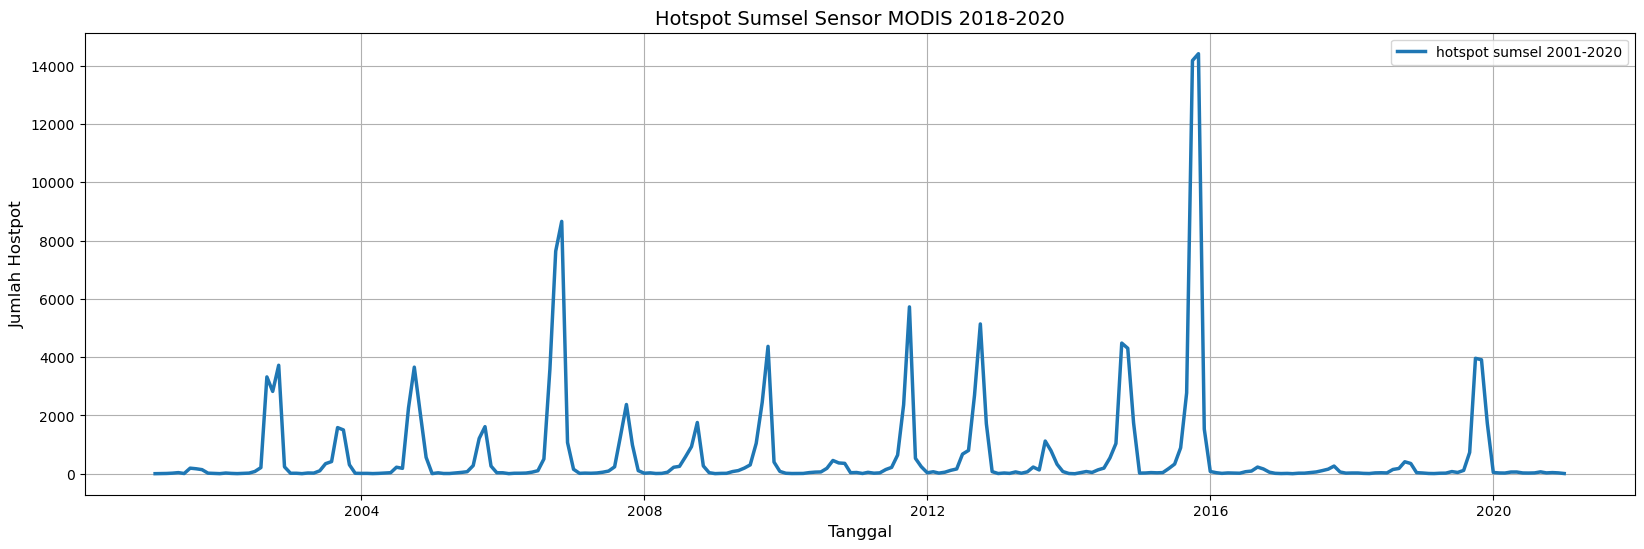

In [7]:
# membuat frame
fig, ax = plt.subplots(figsize = (20,6))

# membuat time series plot
ax.plot(dataset["acq_date"], dataset["hotspot"], color="tab:blue", label="hotspot sumsel 2001-2020", linewidth=2.5)

# membuat label-label
ax.set_title("Hotspot Sumsel Sensor MODIS 2018-2020", fontsize=14)
ax.set_xlabel("Tanggal", fontsize=12)
ax.set_ylabel("Jumlah Hostpot", fontsize=12)
ax.legend(loc='best')
ax.grid(True)

# menampilkan plot
plt.show()

- Analisa ACF dan PACF

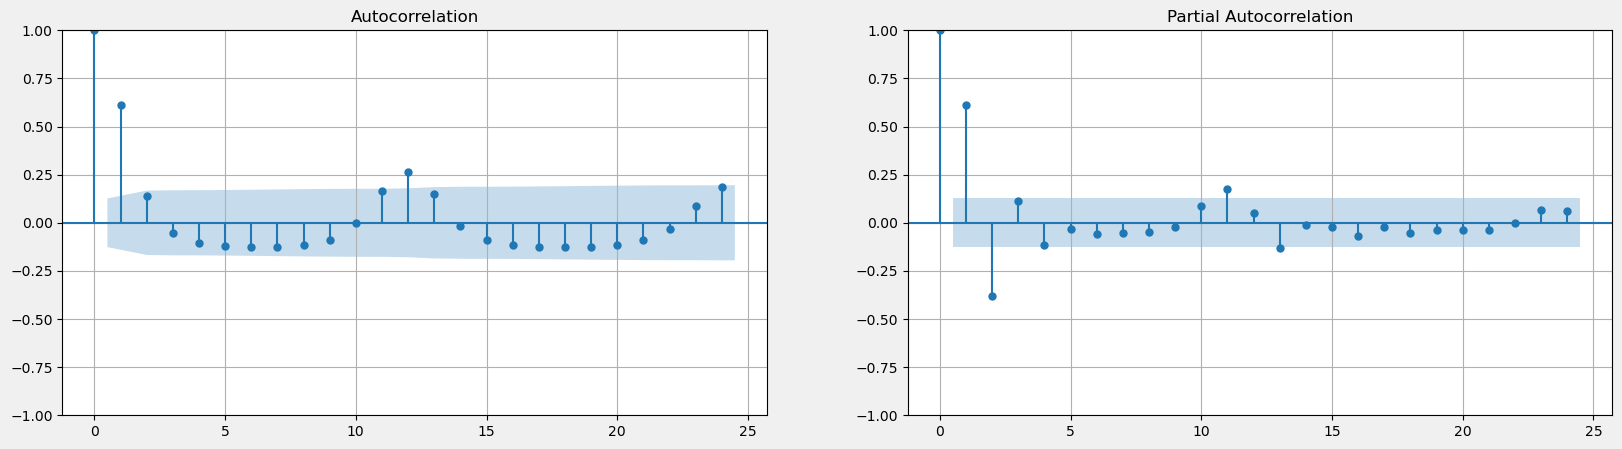

In [8]:
# code autocorrelation
# membuat frame
fig, ax= plt.subplots(nrows=1, ncols=2, facecolor="#F0F0F0", figsize = (20,5))

# plot acf
plot_acf(dataset["hotspot"], lags=24, ax=ax[0])
ax[0].grid(True)

# plot pacf
plot_pacf(dataset["hotspot"],lags=24, ax=ax[1], method="yw")
ax[1].grid(True)

# menampilkan plot acf dan pacf
plt.show()

### 4. Praproses Data

- selesi fitur

In [9]:
# memilh fitur hotspot
df_sumsel = dataset.filter(["hotspot"])

In [10]:
# convert dataframe to series
df_sumsel = df_sumsel.values

In [11]:
np.round(df_sumsel[:5],7)

array([[ 3],
       [ 5],
       [10],
       [20],
       [39]], dtype=int64)

- normalisasi data

In [12]:
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(np.array(df_sumsel).reshape(-1,1))

In [13]:
np.round(scaled_data[:5],7)

array([[-0.9997225],
       [-0.999445 ],
       [-0.9987513],
       [-0.9973639],
       [-0.9947277]])

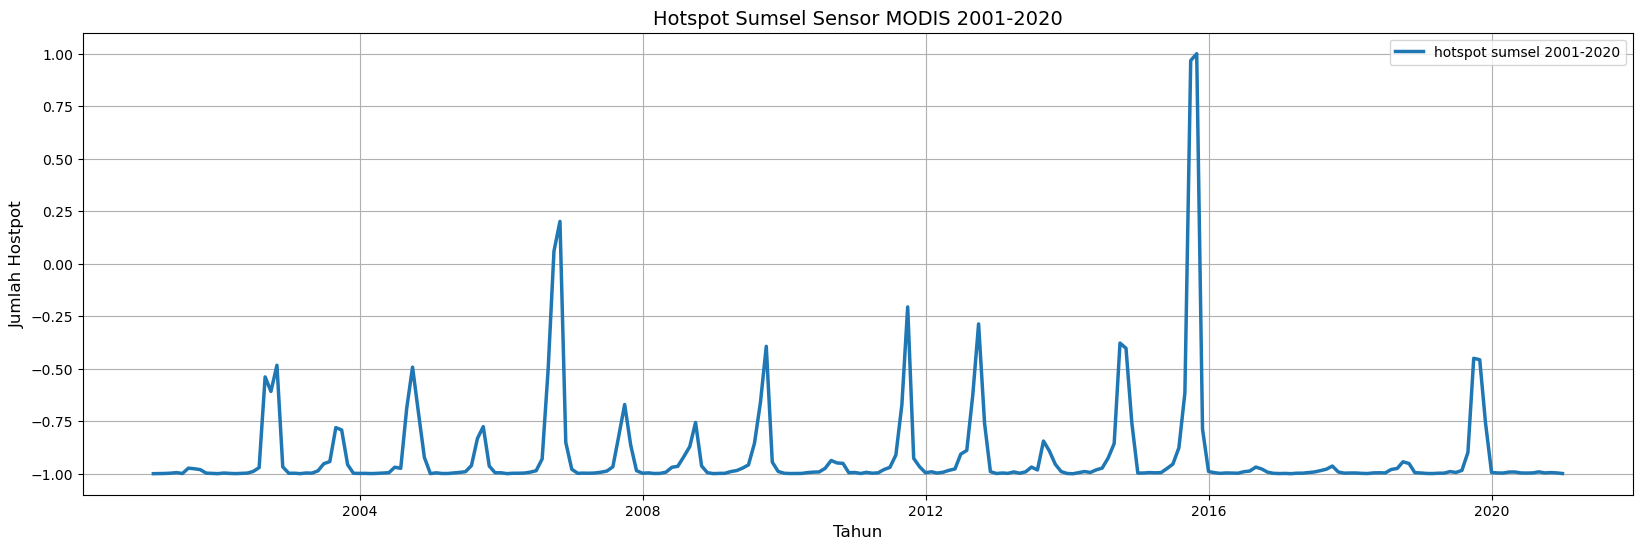

In [14]:
# membuat frame
fig, ax = plt.subplots(figsize = (20,6))

# membuat time series plot
ax.plot(dataset["acq_date"], scaled_data, color="tab:blue", label="hotspot sumsel 2001-2020", linewidth=2.5)

# membuat label-label
ax.set_title("Hotspot Sumsel Sensor MODIS 2001-2020", fontsize=14)
ax.set_xlabel("Tahun", fontsize=12)
ax.set_ylabel("Jumlah Hostpot", fontsize=12)
ax.legend(loc='best')
ax.grid(True)

# menampilkan plot
plt.show()

- Data latih dan Data uji

In [15]:
# split into train and test sets
train_size = int(len(df_sumsel) * 0.8)
test_size = len(df_sumsel) - train_size

In [16]:
train, test = scaled_data[0:train_size,:], scaled_data[train_size:len(df_sumsel),:]

In [17]:
print(train.shape, test.shape)

(192, 1) (48, 1)


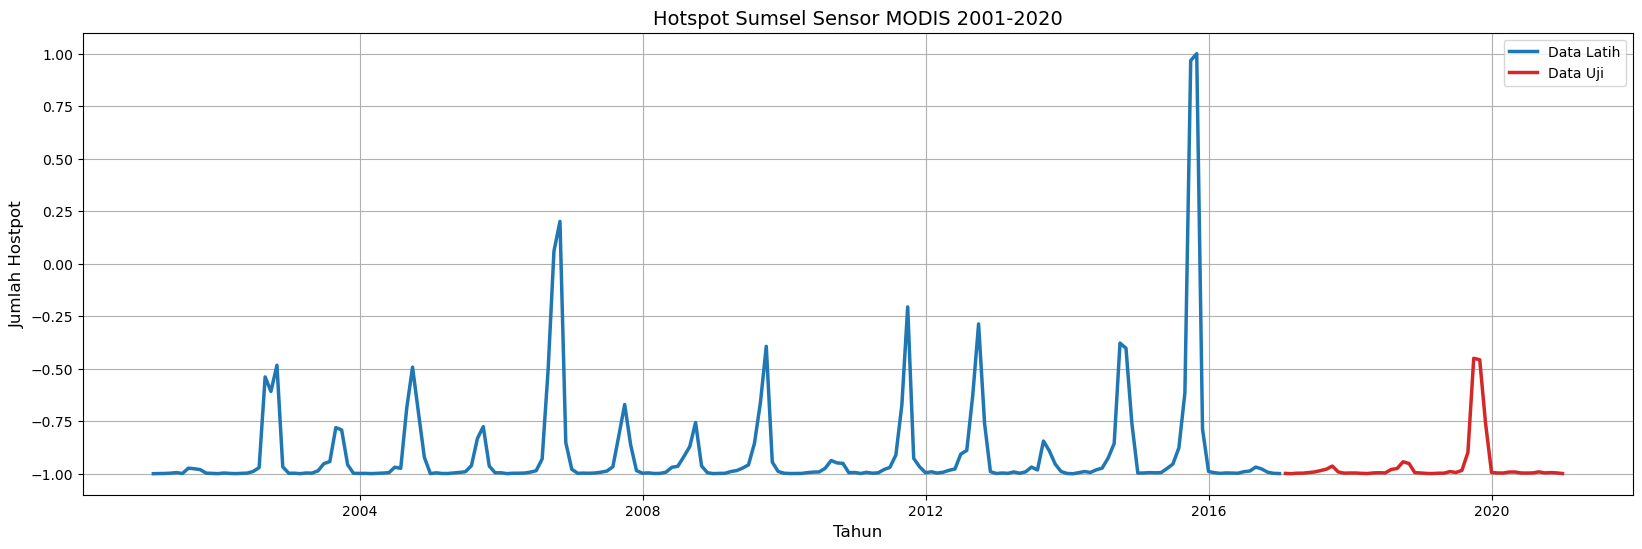

In [18]:
# membuat frame
fig, ax = plt.subplots(figsize = (20,6))

# membuat time series plot
ax.plot(dataset.iloc[0:train_size,0], train, color="tab:blue", label="Data Latih", linewidth=2.5)
ax.plot(dataset.iloc[train_size:len(df_sumsel),0], test, color="tab:red", label="Data Uji", linewidth=2.5)

# membuat label-label
ax.set_title("Hotspot Sumsel Sensor MODIS 2001-2020", fontsize=14)
ax.set_xlabel("Tahun", fontsize=12)
ax.set_ylabel("Jumlah Hostpot", fontsize=12)
ax.legend(loc="best")
ax.grid(True)

# menampilkan plot
plt.show()

- Supervised Learning

In [19]:
# convert an array of values into a dataset matrix

# function for supervised learning
def create_dataset(dataset, look_back):
    
    # declare variable X and Y
    dataX = []
    dataY = []
    
    # for loop for create supervised learning
    for i in range(look_back, len(dataset)):
        
        # insert value X and Y 
        dataX.append(dataset[i-look_back:i, 0])
        dataY.append(dataset[i, 0])
        
    # return value X and Y
    return np.array(dataX), np.array(dataY)

In [20]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [21]:
print(trainX.shape, trainY.shape)

(191, 1) (191,)


In [22]:
print(testX.shape, testY.shape)

(47, 1) (47,)


- reshape input for samples, time steps, features

In [23]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [24]:
print(trainX.shape, trainY.shape)

(191, 1, 1) (191,)


In [25]:
print(testX.shape, testY.shape)

(47, 1, 1) (47,)


### 5. Modeling LSTM-RNN

In [26]:
# Design network
model = Sequential()

# First LSTM layer with Dropout regularisation
model.add(
    LSTM(
        units=10,
        activation='selu',
        input_shape=(trainX.shape[1], 1)
    )
)
model.add(Dropout(0.2))

# The output layer
model.add(Dense(1))

# Compiling model the LSTM-RNN
# lr=0.0075, decay=0.00001
model.compile(
    optimizer='sgd',
    loss='mae',
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(),
        tf.keras.metrics.MeanSquaredError(),
        tf.keras.metrics.RootMeanSquaredError()
    ]
)

In [27]:
# fit network
history = model.fit(trainX, trainY, epochs=2000, batch_size=8,
                    validation_data=(testX, testY),
                    verbose=0, shuffle=False)

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                480       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


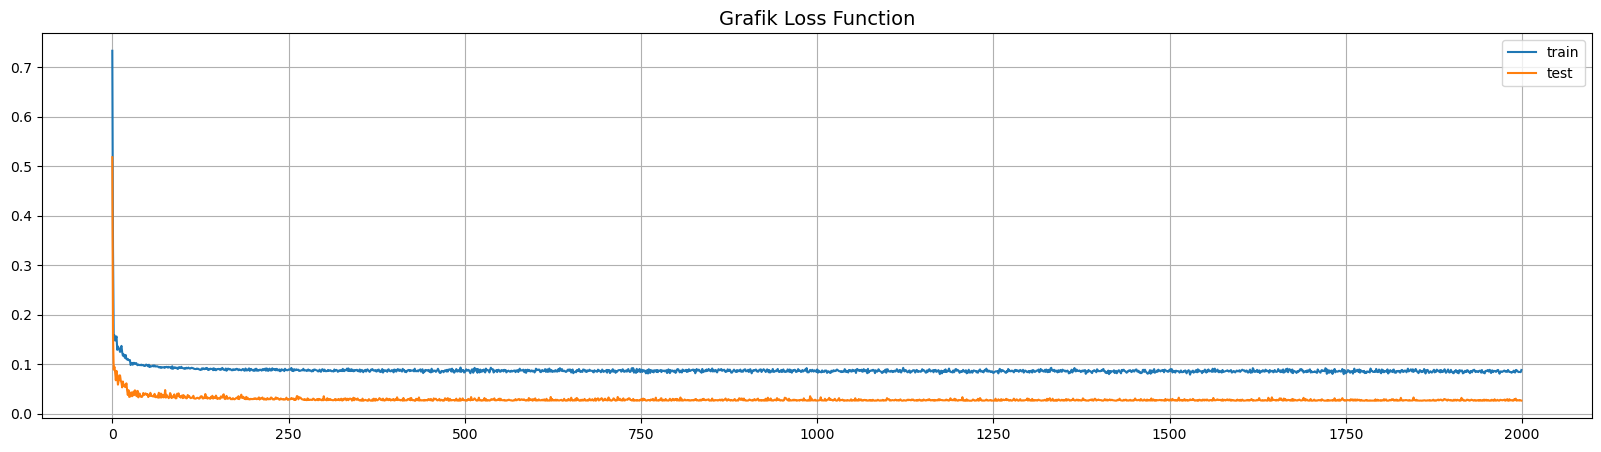

In [29]:
# membuat frame
fig, ax = plt.subplots(figsize = (20,5))

# membuat time series plot
ax.plot(history.history['loss'], color="tab:blue", label="train", linewidth=1.5)
ax.plot(history.history['val_loss'], color="tab:orange", label="test", linewidth=1.5)

# membuat label-label
ax.set_title("Grafik Loss Function", fontsize=14)
ax.legend(loc='upper right')
ax.grid(True)

# menampilkan plot
plt.show()

In [30]:
# make predictions
predictions = model.predict(testX, verbose=0)
print(predictions[:, 0])

[-0.9978106  -0.9982721  -0.99745184 -0.9974006  -0.9963249  -0.9952503
 -0.9923108  -0.9872714  -0.9766386  -0.9953014  -0.9973493  -0.99709314
 -0.99709314 -0.99775934 -0.9980157  -0.9969395  -0.99668336 -0.9969907
 -0.9883551  -0.98484796 -0.9621912  -0.96794873 -0.9964785  -0.99709314
 -0.9979132  -0.99806696 -0.99750304 -0.9973493  -0.9945855  -0.99617136
 -0.99151766 -0.93180203 -0.6977794  -0.7005299  -0.84617233 -0.99617136
 -0.99704194 -0.9971956  -0.9954037  -0.99535257 -0.99704194 -0.9971956
 -0.9969395  -0.99509686 -0.9969395  -0.9963761  -0.9968882 ]


### 6. Evaluasi Model LSTM-RNN

In [31]:
scores = model.evaluate(trainX, trainY)
scores

6/6 [==============================] - 0s 4ms/step - loss: 0.0832 - mean_absolute_error: 0.0832 - mean_squared_error: 0.0479 - root_mean_squared_error: 0.2188


[0.08316239714622498,
 0.08316239714622498,
 0.04787037521600723,
 0.21879298985004425]

In [32]:
scores = model.evaluate(testX, testY)
scores

2/2 [==============================] - 0s 12ms/step - loss: 0.0269 - mean_absolute_error: 0.0269 - mean_squared_error: 0.0070 - root_mean_squared_error: 0.0835


[0.026852654293179512,
 0.026852654293179512,
 0.006979655008763075,
 0.08354432880878448]

- MAE (Mean Absolute Error)

In [33]:
mae = mean_absolute_error(testY, predictions)
print('Test MAE : %.4f' % mae)

Test MAE : 0.0269


- MSE (Mean Squared Error)

In [34]:
mse = mean_squared_error(testY, predictions)
print('Test MSE: %.4f' % mse)

Test MSE: 0.0070


- RMSE (Root Mean Squared Error)

In [35]:
# calculate RMSE
rmse = sqrt(mse)
print('Test RMSE: %.4f' % rmse)

Test RMSE: 0.0835


- Corelation pearson

In [36]:
hasil = np.stack((testY.reshape(-1), predictions.reshape(-1)), axis=1)
hasil = pd.DataFrame(hasil, columns = ['data_aktual','prediksi'])

In [37]:
hasil.head()

,data_aktual,prediksi
0,-0.999723,-0.997811
1,-0.997503,-0.998272
2,-0.997364,-0.997452
3,-0.994450,-0.997401
4,-0.991537,-0.996325


In [38]:
import scipy.stats as sc
r, p = sc.pearsonr(hasil["data_aktual"], hasil["prediksi"])
print("korelasi data akual dengan hasil prediksi" +" {:.4f} ".format(r)+ "dengan signifikansi" +" {:.4f} ".format(p))

korelasi data akual dengan hasil prediksi 0.7054 dengan signifikansi 0.0000 


- Complexity time

In [39]:
# Set akhir waktu komputasi 
end = time.time()

In [40]:
# Proses menghitung waktu komputasi
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)

In [41]:
# Hasil waktu komputasi
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

00:04:39.57


### 7. Visualisasi Data

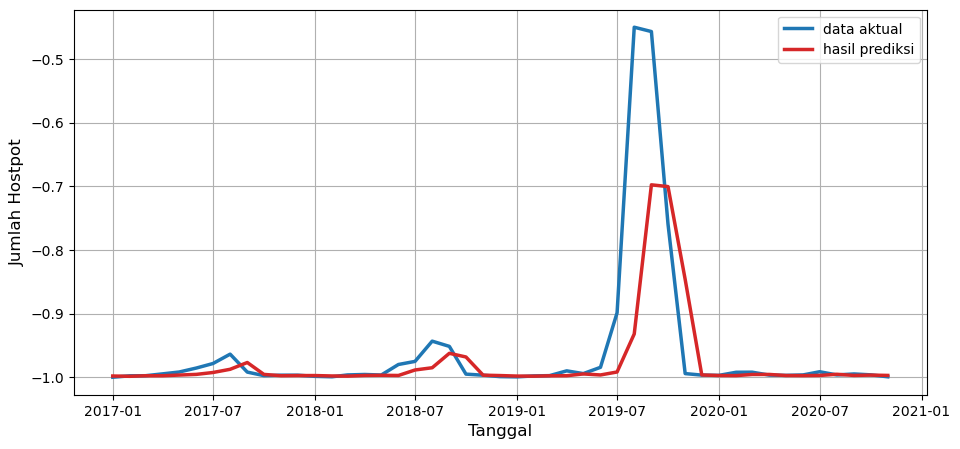

In [51]:
# generate urutan data sesuai panjang datanya
x = pd.date_range(start="2017-01-01", periods=len(testY), freq='MS')

# membuat frame
fig, ax = plt.subplots(figsize = (11,5))

# membuat time series plot
ax.plot(x, testY, color="tab:blue", label="data aktual", linewidth=2.5)
ax.plot(x, predictions, color="tab:red", label="hasil prediksi", linewidth=2.5)

# membuat label-label
# ax.set_title("Hotspot Sumsel Sensor MODIS 2018-2020", fontsize=14)
ax.set_xlabel("Tanggal", fontsize=12)
ax.set_ylabel("Jumlah Hostpot", fontsize=12)
ax.legend(loc='upper right')
ax.grid(True)

# menampilkan plot
plt.show()